# GD4. 자율주행 보조 시스템 만들기

- 자율주행 시스템 생성  
    
    - 이미지 입력  
    
    - 정지 조건에 맞으면 'Stop' 아닌 경우 'Go' 반환  
    
    - 정지 조건: 사람이 1명 이상 있는 경우, 차량의 크기가 300px 이상인 경우  
    

- 자율주행 시스템 평가  
    
    - 'Go', 'Stop'을 맞게 반환하는지 확인하여 평가 (100점 만점)

---
## 0. 사전 준비

In [23]:
# !mkdir -p ~/aiffel/object_detection/data

In [24]:
# !pip uninstall tensorflow
# !pip install tensorflow==2.3.0

In [25]:
# !cd ~/aiffel/object_detection
# !git clone https://github.com/fizyr/keras-retinanet.git
# # !cd keras-retinanet && python setup.py build_ext --inplace

In [26]:
# !pip install -r requirements.txt
# !pip install .

In [27]:
!pip install progressbar

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [28]:
!pip install progressbar2

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


---
## 1. 데이터 준비

- `tensorflow_datasets`에서 제공하는 `KITTI` 데이터셋 사용  

    - 자율주행을 위한 데이터셋    

    -  2D object detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공  

    - 일반적으로 보는 사진보다 광각으로 촬영되어 다양한 각도의 물체를 확인 가능  

    - 데이터 구성: 라벨에는 alpha, bbox, dimensions, location, occluded, rotation_y, truncated 등의 정보  

        - 6,347개의 학습 데이터(training data)  

        - 711개의 평가용 데이터(test data)  

        - 423개의 검증용 데이터(validation data)  
        

In [29]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw
import progressbar

In [30]:
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"), "aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=data_dir,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

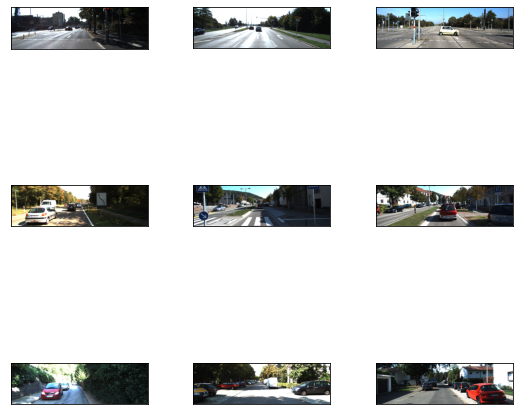

In [29]:
_ = tfds.show_examples(ds_train, ds_info)

In [30]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

---
## 2. 데이터 확인

In [31]:
sample = ds_train.take(1)

In [32]:
for example in sample:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.64], dtype=float32)>, 'bbox': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.14327027, 0.8089379 , 0.61494595, 0.8568709 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.82, 0.57, 1.01]], dtype=float32)>, 'location': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[4.51, 1.43, 7.72]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, 'rotation_y': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-3.13], dtype=float32)>, 'truncated': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, 'type': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>}


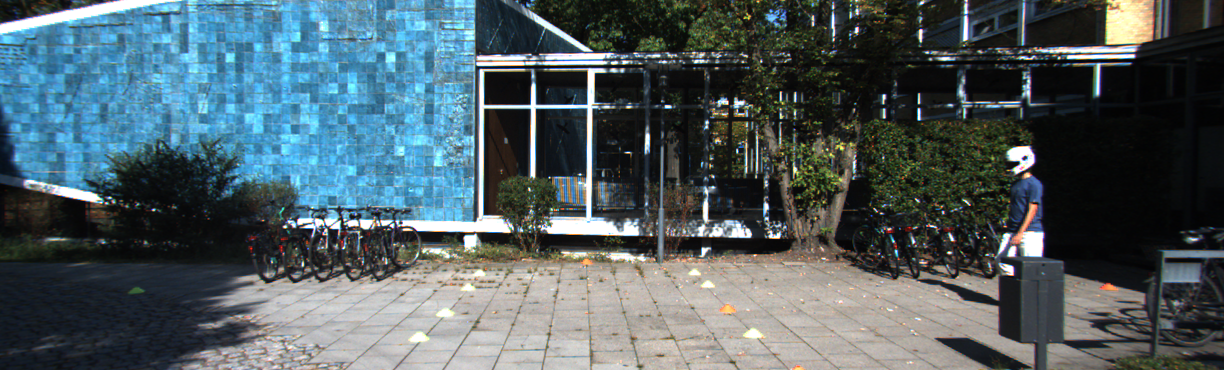

In [33]:
img

In [31]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

width: 1224  height: 370
(1, 4)
[ 990.14    316.99   1048.8099  142.47  ]
<PIL.Image.Image image mode=RGB size=1224x370 at 0x7F88D820A790>


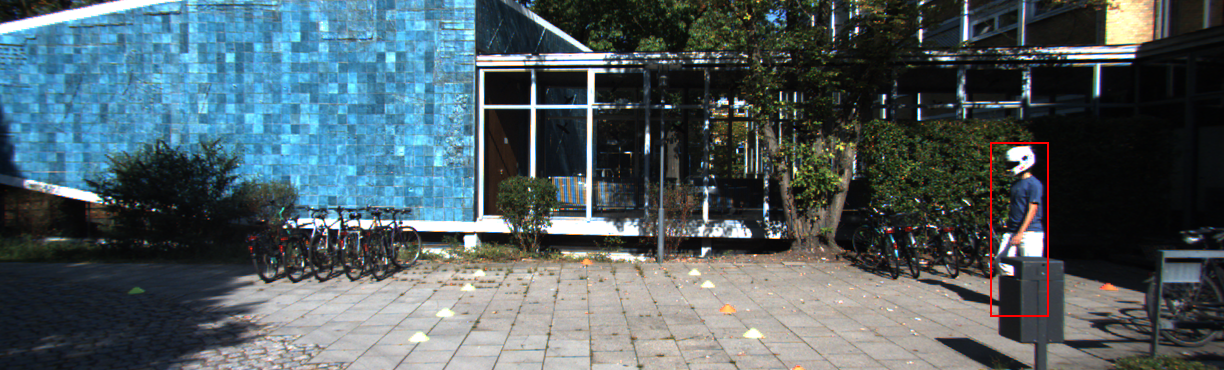

In [35]:
visualize_bbox(img, objects['bbox'].numpy())

---
## 3. 데이터 포멧 변경

- `Keras RetinaNet`은: 케라스(Keras) 라이브러리로 구현된 `RetinaNet`
- 아직 커스텀 데이터셋을 학습하는 방법을 공식 문서로 제시하지 않고 있음
- 해당 모델을 훈련할 수 있는 공통된 데이터셋 포맷인 CSV 형태로 변경


### 3-1. 클래스 및 바운딩 박스 정보 추출
- API를 활용하여 데이터를 추출, 이를 포맷팅 하여 CSV 형태로 한 줄씩 저장
- 한 라인에 이미지 파일의 위치, 바운딩 박스 위치, 그리고 클래스 정보를 가지는 CSV 파일을 작성하도록 코드를 작성하고, 이를 사용해 CSV 파일을 생성

In [32]:
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            
    return df

In [33]:
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

100%|██████████| 6347/6347 [25:13<00:00,  4.19it/s]


In [34]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:54<00:00,  4.08it/s]


### 3-2. 클래스 맵핑
- 숫자를 사용해 클래스를 표시
- 각 클래스가 어떤 인덱스(index)에 맵핑(mapping)될지 미리 정하고 저장
- 학습 후 추론(inference) 할 때에도 숫자 인덱스로 나온 정보를 클래스 이름으로 바꾸어 해석
- 자동차와 사람을 구별하기 위한 클래스 맵핑 함수 생성


In [35]:
class_txt_path = data_dir + '/classes.txt'

In [36]:
def save_class_format(path):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
    print('Done')           

In [37]:
save_class_format(class_txt_path)

Done


---
## 4. 환경 셋팅
- 미리 설치해 둔 케라스 및 Keras RetinaNet 리포지토리를 사용
- 학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환
- 각 epochs 1, 10, 20 으로 진행

### 4-1. Epochs 1

In [50]:
# RetinaNet 훈련 시작. 10epoch 훈련에 1시간 이상 소요
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 1 --steps 195 csv data/kitti_train.csv data/classes.txt
print("Done")

2022-01-02 08:32:26.428646: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-02 08:32:28.420497: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-02 08:32:28.421595: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-02 08:32:28.448798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-02 08:32:28.449572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8755GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-01-02 08:32:28.449615: I tensorflow/stream_executor/platform/default/dso_lo

2022-01-02 08:32:34.667372: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-02 08:32:34.685952: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299995000 Hz
2022-01-02 08:32:45.062890: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-01-02 08:32:46.557190: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-01-02 08:32:46.605720: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-01-02 08:32:47.314920: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-02 08:32:47.543721: I tensorflow/stream

In [51]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_01.h5 snapshots/resnet50_csv_01_infer.h5
print("Done")

2022-01-02 08:37:26.633849: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-02 08:37:28.423311: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-02 08:37:28.424396: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-02 08:37:28.448552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-02 08:37:28.449335: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8755GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-01-02 08:37:28.449374: I tensorflow/stream_executor/platform/default/dso_lo

### 4-2. Epochs 10

In [12]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt

2022-01-02 09:33:53.022647: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-02 09:33:55.048997: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-02 09:33:55.050253: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-02 09:33:55.076880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-02 09:33:55.077722: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8755GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-01-02 09:33:55.077765: I tensorflow/stream_executor/platform/default/dso_lo

bn4d_branch2c (BatchNormalizati (None, None, None, 1 4096        res4d_branch2c[0][0]             
__________________________________________________________________________________________________
res4d (Add)                     (None, None, None, 1 0           bn4d_branch2c[0][0]              
                                                                 res4c_relu[0][0]                 
__________________________________________________________________________________________________
res4d_relu (Activation)         (None, None, None, 1 0           res4d[0][0]                      
__________________________________________________________________________________________________
res4e_branch2a (Conv2D)         (None, None, None, 2 262144      res4d_relu[0][0]                 
__________________________________________________________________________________________________
bn4e_branch2a (BatchNormalizati (None, None, None, 2 1024        res4e_branch2a[0][0]             
__________

2022-01-02 09:34:00.568430: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-02 09:34:00.585997: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299995000 Hz
Epoch 1/10
2022-01-02 09:34:10.993991: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-01-02 09:34:12.608724: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-01-02 09:34:12.661378: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-01-02 09:34:13.196503: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-02 09:34:13.434402: I tensor

In [13]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5

2022-01-02 10:11:43.464835: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-02 10:11:45.245918: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-02 10:11:45.247032: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-02 10:11:45.272656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-02 10:11:45.273449: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8755GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-01-02 10:11:45.273492: I tensorflow/stream_executor/platform/default/dso_lo

### 4-3. Epochs 20

In [38]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 20 --steps 195 csv data/kitti_train.csv data/classes.txt

2022-01-02 12:50:57.362703: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-02 12:50:59.429353: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-02 12:50:59.430631: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-02 12:50:59.457109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-02 12:50:59.457606: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8755GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-01-02 12:50:59.457654: I tensorflow/stream_executor/platform/default/dso_lo

bn4b_branch2a (BatchNormalizati (None, None, None, 2 1024        res4b_branch2a[0][0]             
__________________________________________________________________________________________________
res4b_branch2a_relu (Activation (None, None, None, 2 0           bn4b_branch2a[0][0]              
__________________________________________________________________________________________________
padding4b_branch2b (ZeroPadding (None, None, None, 2 0           res4b_branch2a_relu[0][0]        
__________________________________________________________________________________________________
res4b_branch2b (Conv2D)         (None, None, None, 2 589824      padding4b_branch2b[0][0]         
__________________________________________________________________________________________________
bn4b_branch2b (BatchNormalizati (None, None, None, 2 1024        res4b_branch2b[0][0]             
__________________________________________________________________________________________________
res4b_bran

2022-01-02 12:51:04.970547: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-02 12:51:04.989976: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299995000 Hz
Epoch 1/20
2022-01-02 12:51:15.607737: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-01-02 12:51:17.180934: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-01-02 12:51:17.233131: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-01-02 12:51:17.838801: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-02 12:51:18.088630: I tensor

195/195 [==============================] - 217s 1s/step - loss: 1.5098 - regression_loss: 1.3157 - classification_loss: 0.1940

Epoch 00012: saving model to ./snapshots/resnet50_csv_12.h5
Epoch 13/20
195/195 [==============================] - 217s 1s/step - loss: 1.3867 - regression_loss: 1.2124 - classification_loss: 0.1743

Epoch 00013: saving model to ./snapshots/resnet50_csv_13.h5
Epoch 14/20
195/195 [==============================] - 217s 1s/step - loss: 1.3901 - regression_loss: 1.2262 - classification_loss: 0.1640

Epoch 00014: saving model to ./snapshots/resnet50_csv_14.h5
Epoch 15/20
195/195 [==============================] - 217s 1s/step - loss: 1.3302 - regression_loss: 1.1654 - classification_loss: 0.1648

Epoch 00015: saving model to ./snapshots/resnet50_csv_15.h5
Epoch 16/20
195/195 [==============================] - 217s 1s/step - loss: 1.3324 - regression_loss: 1.1700 - classification_loss: 0.1625

Epoch 00016: saving model to ./snapshots/resnet50_csv_16.h5
Epoch 17/20


In [39]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_20.h5 snapshots/resnet50_csv_20_infer.h5

2022-01-02 14:05:38.424412: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-02 14:05:40.332128: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-02 14:05:40.333245: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-02 14:05:40.356569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-02 14:05:40.357038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8755GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-01-02 14:05:40.357079: I tensorflow/stream_executor/platform/default/dso_lo

---
## 5. 시각화

In [40]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


In [58]:
# epochs 1
dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_01_infer.h5')
model_01= load_model(model_path, backbone_name='resnet50')

In [15]:
# epochs 10
dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5')
model_10= load_model(model_path, backbone_name='resnet50')

In [42]:
# epochs 20
dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_20_infer.h5')
model_20= load_model(model_path, backbone_name='resnet50')

In [43]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

In [44]:
def inference_on_image(model, img_path, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
#             print(box)
            # score가 0.5보다 적다면 박스를 나타내지 않는다.
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()           

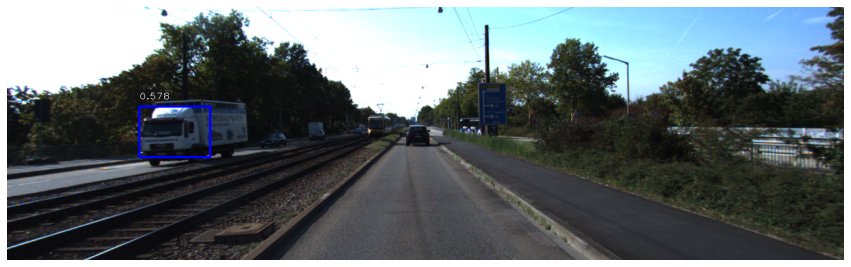

In [59]:
# epochs 1
inference_on_image(model_01, img_path)

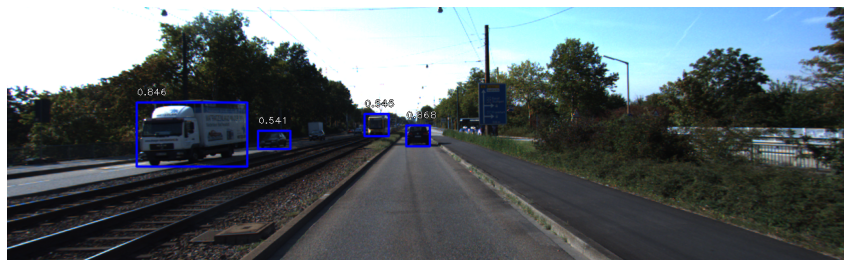

In [18]:
# epochs 10
inference_on_image(model_10, img_path)

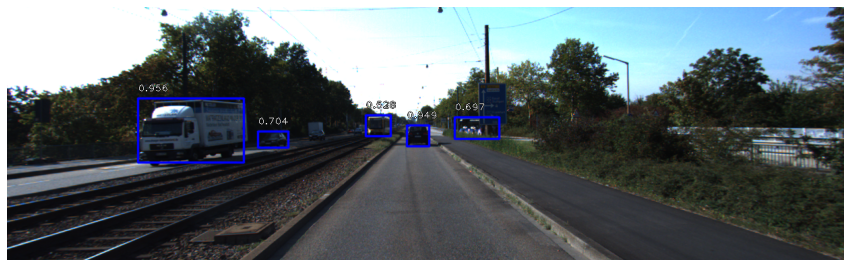

In [45]:
# epochs 20
inference_on_image(model_20, img_path)

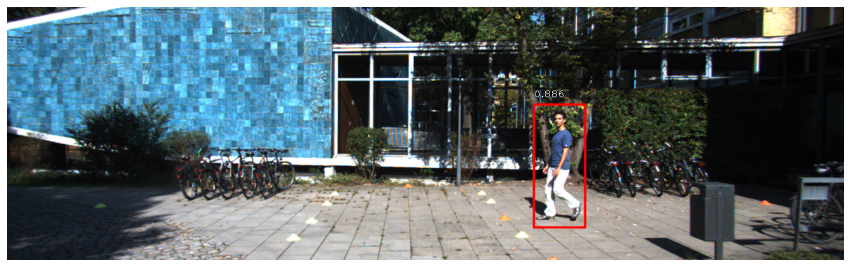

In [51]:
# epochs 20, stop 이미지 적용
img_path2 = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model_20, img_path2)

---
## 6. 자율주행 보조 시스템 만들기

### 6-1. 자율주행 시스템 만들기
- 입력으로 이미지 경로를 받음
- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환
- 조건: 사람이 한 명 이상 있는 경우, 차량의 크기(width or height)가 300px이상인 경우
- epochs 1, 10, 20 결과 확인

In [46]:
def self_drive_assist(model, img_path, size_limit=300):
    image = read_image_bgr(img_path)
    image = preprocess_image(image)
    image, scale = resize_image(image)
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    boxes /= scale

    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        a = box[2]-box[0] # x2 - x1
        b = box[3]-box[1] # y2 - y1
        if score < 0.5:
            break
        if label == 1:
            return 'Stop'
        elif label == 0 and (a >= size_limit or b >= size_limit):
            return 'Stop'
        else:
            return 'Go'

In [62]:
# epochs 1
print(self_drive_assist(model_01, img_path))

Go


In [20]:
# epochs 10
print(self_drive_assist(model_10, img_path))

Go


In [47]:
# epochs 20
print(self_drive_assist(model_20, img_path))

Go


In [52]:
# epochs 20 + stop 이미지
print(self_drive_assist(model_20, img_path2))

Stop


### 6-2. 자율주행 시스템 평가하기
- 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가
- epochs 1, 10, 20 결과 확인

In [48]:
def test_system(model,func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(model, image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

In [72]:
# epochs 1
test_system(model_01, self_drive_assist)

40점입니다.


In [22]:
# epochs 10
test_system(model_10, self_drive_assist)

70점입니다.


In [49]:
# epochs 20
test_system(model_20, self_drive_assist)

100점입니다.


---
## 7. 평가 및 회고

### 루브릭

|평가문항|상세기준|
|:---|:---|
|1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.|KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.|
|2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.|바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.|
|3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.|테스트 수행결과 90% 이상의 정확도를 보였다.|



### 회고

 - 평소 자율 주행에 대한 궁금증을 많이 가지고 있었음에 이번 프로젝트는 흥미롭게 진행할 수 있었다.  

 - epochs를 1, 10, 20으로 설정하여 진행해보았으며, epochs에 따른 탐지 차이가 눈에 띄게 나타나는 것을 확인할 수 있었다.  

 - 탐지 차이 뿐만 아니라 구현한 함수를 통해 확인한 정확도(점수)를 함께 고려한다면 epochs 를 증가시킴에 따라 정확도와 성능을 개선시킬 수 있지 않을까 조심스럽게 생각한다.    

- 중간에 progressbar 오류가 계속 나서 install 했더니 오류가 해결되었다.  

- 좋은 경험을 할 수 있었던 프로젝트였던 것 같다.  
 

---
## 참고 자료

[cvlibs에서 제공하는 KITTI 데이터셋](http://www.cvlibs.net/datasets/kitti/)

[Pillow 라이브러리의 ImageDraw 모듈](https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html)

[Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)

[김홍배님의 Focal loss의 응용(Detection & Classification)](https://www.slideshare.net/ssuser06e0c5/focal-loss-detection-classification)

[tqdm](https://github.com/tqdm/tqdm)

[CSV input produces OOM (out of memory) error on GPU](https://github.com/fizyr/keras-retinanet/issues/499)
